In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math
from rdkit.Chem import AllChem
import rdkit
Chem = rdkit.Chem
from rdkit.Chem import GraphDescriptors
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator

In [3]:
baseall = pd.read_csv('./data/base_all.tsv', sep = '\t')

In [4]:
baseall.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value
0,CHEMBL247416,NaN,NaN,541.64,1.0,3.56,"18, diastereomers",CC1CC1CNc1cc(C(=O)N[C@@H](Cc2ccccc2)[C@@H](N)C...,IC50,'=',...,SINGLE PROTEIN,CHEMBL1139116,1,Scientific Literature,Bioorg Med Chem Lett,2007,NaN,NaN,NaN,NaN
1,CHEMBL429477,NaN,NaN,575.78,1.0,2.68,27,COCCN(C[C@H]1C[C@@H]1C)c1cc(C(=O)N[C@@H](Cc2cc...,IC50,'=',...,SINGLE PROTEIN,CHEMBL1139116,1,Scientific Literature,Bioorg Med Chem Lett,2007,NaN,NaN,NaN,NaN
2,CHEMBL393850,NaN,NaN,445.59,0.0,1.85,"16, diastereomers",CC1CC1CNc1cc(C(=O)N[C@H](CN)Cc2ccccc2)cc(N(C)S...,IC50,'=',...,SINGLE PROTEIN,CHEMBL1139116,1,Scientific Literature,Bioorg Med Chem Lett,2007,NaN,NaN,NaN,NaN
3,CHEMBL1546,HYDROXYAMPHETAMINE,4.0,151.21,0.0,1.28,2,CC(N)Cc1ccc(O)cc1,IC50,'>',...,SINGLE PROTEIN,CHEMBL1142369,1,Scientific Literature,Bioorg Med Chem Lett,2008,NaN,NaN,NaN,NaN
4,CHEMBL502753,NaN,NaN,751.97,2.0,5.02,10,CC(C)C[C@H](NC(=O)c1cc(C(=O)N[C@H](C)c2ccc(F)c...,IC50,'<',...,SINGLE PROTEIN,CHEMBL1152701,1,Scientific Literature,Bioorg Med Chem,2009,CHEMBL3307715,NaN,NaN,NaN


In [5]:
baseall.shape

(10619, 47)

#### Exploratory Data Analysis

In [7]:
# check missing values
baseall.isna().sum()

Molecule ChEMBL ID                0
Molecule Name                 10427
Molecule Max Phase            10547
Molecular Weight                  0
#RO5 Violations                  65
AlogP                            65
Compound Key                      0
Smiles                            0
Standard Type                     0
Standard Relation               147
Standard Value                  147
Standard Units                  147
pChEMBL Value                   903
Data Validity Comment         10364
Comment                        6400
Uo Units                        147
Ligand Efficiency BEI           931
Ligand Efficiency LE            972
Ligand Efficiency LLE           972
Ligand Efficiency SEI           972
Potential Duplicate               0
Assay ChEMBL ID                   0
Assay Description                 0
Assay Type                        0
BAO Format ID                     0
BAO Label                         0
Assay Organism                 2519
Assay Tissue ChEMBL ID      

##### Check for duplicates of IDs

In [8]:
baseall.shape

(10619, 47)

In [9]:
baseall = baseall.drop_duplicates(subset=['Molecule ChEMBL ID'])

In [12]:
baseall.shape

(7464, 47)

In [13]:
# Target organism
baseall["Target Organism"].unique()

array(['Homo sapiens'], dtype=object)

#### Select columns necessory for further analysis

In [14]:
baseall = baseall[['Molecule ChEMBL ID', 'Molecular Weight', 'Standard Value', 'Standard Units', '#RO5 Violations', 'AlogP',  'Smiles']]
baseall

,Molecule ChEMBL ID,Molecular Weight,Standard Value,Standard Units,#RO5 Violations,AlogP,Smiles
0,CHEMBL247416,541.64,2.0,nM,1.0,3.56,CC1CC1CNc1cc(C(=O)N[C@@H](Cc2ccccc2)[C@@H](N)C...
1,CHEMBL429477,575.78,66.0,nM,1.0,2.68,COCCN(C[C@H]1C[C@@H]1C)c1cc(C(=O)N[C@@H](Cc2cc...
2,CHEMBL393850,445.59,279.0,nM,0.0,1.85,CC1CC1CNc1cc(C(=O)N[C@H](CN)Cc2ccccc2)cc(N(C)S...
3,CHEMBL1546,151.21,100000.0,nM,0.0,1.28,CC(N)Cc1ccc(O)cc1
4,CHEMBL502753,751.97,1000.0,nM,2.0,5.02,CC(C)C[C@H](NC(=O)c1cc(C(=O)N[C@H](C)c2ccc(F)c...
...,...,...,...,...,...,...,...
10614,CHEMBL5220695,377.49,15.1,nM,0.0,3.35,CC(C)(C)OC(=O)Nc1ccc(O)c(C(=O)NCCCN2CCCCC2)c1
10615,CHEMBL5187186,329.81,96.0,nM,0.0,4.15,C[C@@]1(c2cc(-c3ccc(Cl)cn3)ccc2F)C[C@@H]2C[C@@...
10616,CHEMBL5184716,371.39,851.0,nM,0.0,3.14,COc1cnc(-c2ccc(F)c([C@]3(CF)CC[C@](C)(C#N)C(N)...
10617,CHEMBL5186773,389.38,12.0,nM,0.0,3.43,COc1cnc(-c2ccc(F)c([C@]3(C(F)F)CC[C@@](C)(C#N)...


In [15]:
baseall = baseall.rename(columns={'Molecule ChEMBL ID': 'ChEMBL ID', 'Standard Value': 'IC50'})

In [16]:
#Change column name 'standard Value'  to 'IC50' and 'Molecule ChEMBL ID' to 'ChEMBL ID'
baseall = baseall.rename(columns={'Molecule ChEMBL ID': 'ChEMBL ID', 'Standard Value': 'IC50'})

In [17]:
baseall

,ChEMBL ID,Molecular Weight,IC50,Standard Units,#RO5 Violations,AlogP,Smiles
0,CHEMBL247416,541.64,2.0,nM,1.0,3.56,CC1CC1CNc1cc(C(=O)N[C@@H](Cc2ccccc2)[C@@H](N)C...
1,CHEMBL429477,575.78,66.0,nM,1.0,2.68,COCCN(C[C@H]1C[C@@H]1C)c1cc(C(=O)N[C@@H](Cc2cc...
2,CHEMBL393850,445.59,279.0,nM,0.0,1.85,CC1CC1CNc1cc(C(=O)N[C@H](CN)Cc2ccccc2)cc(N(C)S...
3,CHEMBL1546,151.21,100000.0,nM,0.0,1.28,CC(N)Cc1ccc(O)cc1
4,CHEMBL502753,751.97,1000.0,nM,2.0,5.02,CC(C)C[C@H](NC(=O)c1cc(C(=O)N[C@H](C)c2ccc(F)c...
...,...,...,...,...,...,...,...
10614,CHEMBL5220695,377.49,15.1,nM,0.0,3.35,CC(C)(C)OC(=O)Nc1ccc(O)c(C(=O)NCCCN2CCCCC2)c1
10615,CHEMBL5187186,329.81,96.0,nM,0.0,4.15,C[C@@]1(c2cc(-c3ccc(Cl)cn3)ccc2F)C[C@@H]2C[C@@...
10616,CHEMBL5184716,371.39,851.0,nM,0.0,3.14,COc1cnc(-c2ccc(F)c([C@]3(CF)CC[C@](C)(C#N)C(N)...
10617,CHEMBL5186773,389.38,12.0,nM,0.0,3.43,COc1cnc(-c2ccc(F)c([C@]3(C(F)F)CC[C@@](C)(C#N)...


In [18]:
# drop rows with missing values
baseall = baseall.dropna(axis=1, how='all')

In [19]:
baseall.head()

,ChEMBL ID,Molecular Weight,IC50,Standard Units,#RO5 Violations,AlogP,Smiles
0,CHEMBL247416,541.64,2.0,nM,1.0,3.56,CC1CC1CNc1cc(C(=O)N[C@@H](Cc2ccccc2)[C@@H](N)C...
1,CHEMBL429477,575.78,66.0,nM,1.0,2.68,COCCN(C[C@H]1C[C@@H]1C)c1cc(C(=O)N[C@@H](Cc2cc...
2,CHEMBL393850,445.59,279.0,nM,0.0,1.85,CC1CC1CNc1cc(C(=O)N[C@H](CN)Cc2ccccc2)cc(N(C)S...
3,CHEMBL1546,151.21,100000.0,nM,0.0,1.28,CC(N)Cc1ccc(O)cc1
4,CHEMBL502753,751.97,1000.0,nM,2.0,5.02,CC(C)C[C@H](NC(=O)c1cc(C(=O)N[C@H](C)c2ccc(F)c...


In [20]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [21]:
baseall["pIC50"] = baseall.apply(lambda x: round(convert_ic50_to_pic50(x.IC50), 2), axis=1)

In [22]:
baseall.head()

,ChEMBL ID,Molecular Weight,IC50,Standard Units,#RO5 Violations,AlogP,Smiles,pIC50
0,CHEMBL247416,541.64,2.0,nM,1.0,3.56,CC1CC1CNc1cc(C(=O)N[C@@H](Cc2ccccc2)[C@@H](N)C...,8.70
1,CHEMBL429477,575.78,66.0,nM,1.0,2.68,COCCN(C[C@H]1C[C@@H]1C)c1cc(C(=O)N[C@@H](Cc2cc...,7.18
2,CHEMBL393850,445.59,279.0,nM,0.0,1.85,CC1CC1CNc1cc(C(=O)N[C@H](CN)Cc2ccccc2)cc(N(C)S...,6.55
3,CHEMBL1546,151.21,100000.0,nM,0.0,1.28,CC(N)Cc1ccc(O)cc1,4.00
4,CHEMBL502753,751.97,1000.0,nM,2.0,5.02,CC(C)C[C@H](NC(=O)c1cc(C(=O)N[C@H](C)c2ccc(F)c...,6.00


In [23]:
baseall.dtypes

ChEMBL ID            object
Molecular Weight    float64
IC50                float64
Standard Units       object
#RO5 Violations     float64
AlogP               float64
Smiles               object
pIC50               float64
dtype: object

In [24]:
baseall['pIC50'].max(), baseall['pIC50'].min()

(12.7, 1.07)

#### EDA:Plots for drug like properties

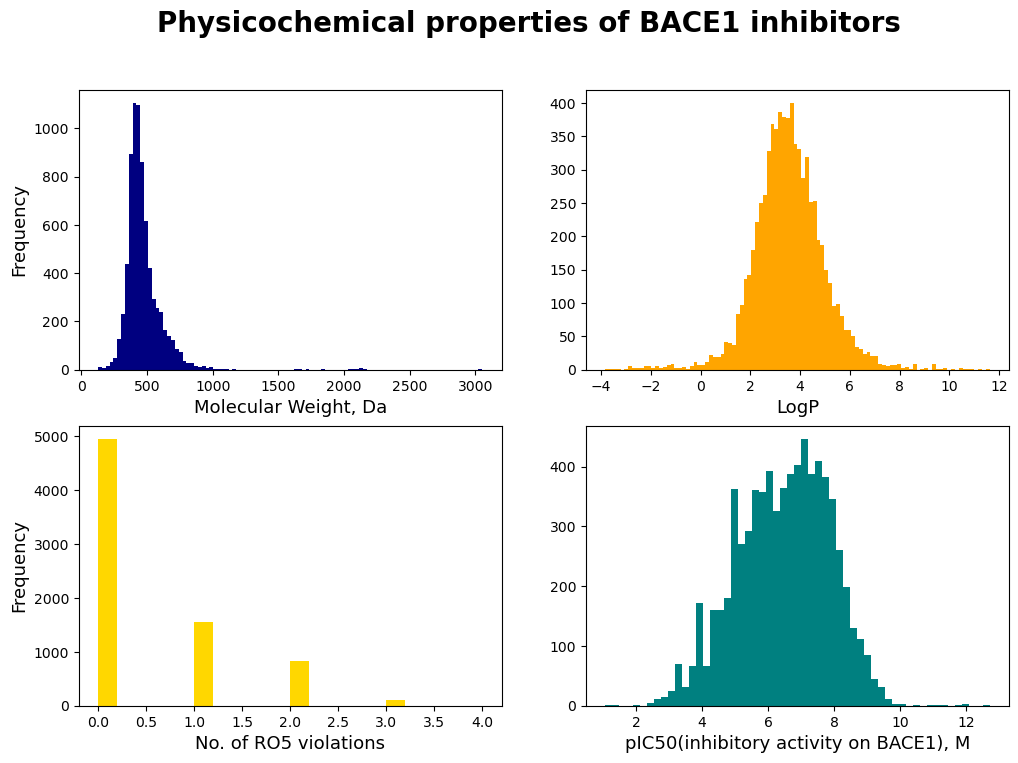

In [31]:
fig, (axes) = plt.subplots(2,2, figsize = (12,8))

axes[0,0].hist(baseall['Molecular Weight'], color = 'navy', bins = 100)
axes[0,0].set_xlabel('Molecular Weight, Da', fontsize = 13)
axes[0,0].set_ylabel('Frequency', fontsize = 13)
axes[0,1].hist(baseall['AlogP'], color = 'orange', bins = 100)
axes[0,1].set_xlabel('LogP', fontsize = 13)
# axes[0,2].hist(emb_bios['HBA'], color = 'skyblue', bins = 15)
# axes[0,2].set_xlabel('No. hydrogen bond acceptors')
# axes[1,0].hist(emb_bios['HBD'], color = 'rosybrown', bins = 15)
# axes[1,0].set_ylabel('Frequency')
# axes[1,0].set_xlabel('No. of hydrogen bond donors')
axes[1,0].hist(baseall['#RO5 Violations'], color = 'gold', bins = 20)
axes[1,0].set_ylabel('Frequency', fontsize = 13)
axes[1,0].set_xlabel('No. of RO5 violations', fontsize = 13)
axes[1,1].hist(baseall['pIC50'], color = 'teal', bins = 55)
axes[1,1].set_xlabel('pIC50(inhibitory activity on BACE1), M', fontsize = 13)
fig.suptitle('Physicochemical properties of BACE1 inhibitors', fontweight="bold", fontsize=20);

##### Save filtered Data

In [24]:
baseall.to_csv('./data/base_inhibitors.csv', index = False)